In [4]:
!pip install pymorphy2

In [5]:
import json
import collections
import numpy as np
import pymorphy2
import requests
analyzer = pymorphy2.MorphAnalyzer()

In [6]:
with open('new_corpus.json', 'r') as f:
    dict_corpus = json.load(f)

In [21]:
dict_corpus['0']

'Северодвинск  — город в Архангельской области России, административный центр муниципального образования «Северодвинск». Основан в 1936 году как рабочий судостроительный посёлок, получил статус города в 1938 году. В 2016 году получил статус Города трудовой доблести и славы. Распоряжением правительства РФ от 16 апреля 2015 года № 668-р «Об утверждении перечня моногородов» город Северодвинск включён в категорию «Монопрофильные муниципальные образования Российской Федерации  со стабильной социально-экономической ситуацией». Северодвинск официально отнесён к районам Крайнего Севера.'

In [7]:
import string

Проведем токенизацию

In [8]:
punct = string.punctuation + "—" + "«" + "»"
tokens = []
for documents in dict_corpus.values():
    documents_token = documents.split()
    tokens.append([x for x in documents_token if x not in punct])

In [9]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Уберем стоп-слова

In [10]:
stopwords_list = stopwords.words("russian")
wout_sw = []
for x in range (0, len(tokens)):
  wout_sw.append([word for word in tokens[x] if word not in stopwords_list])

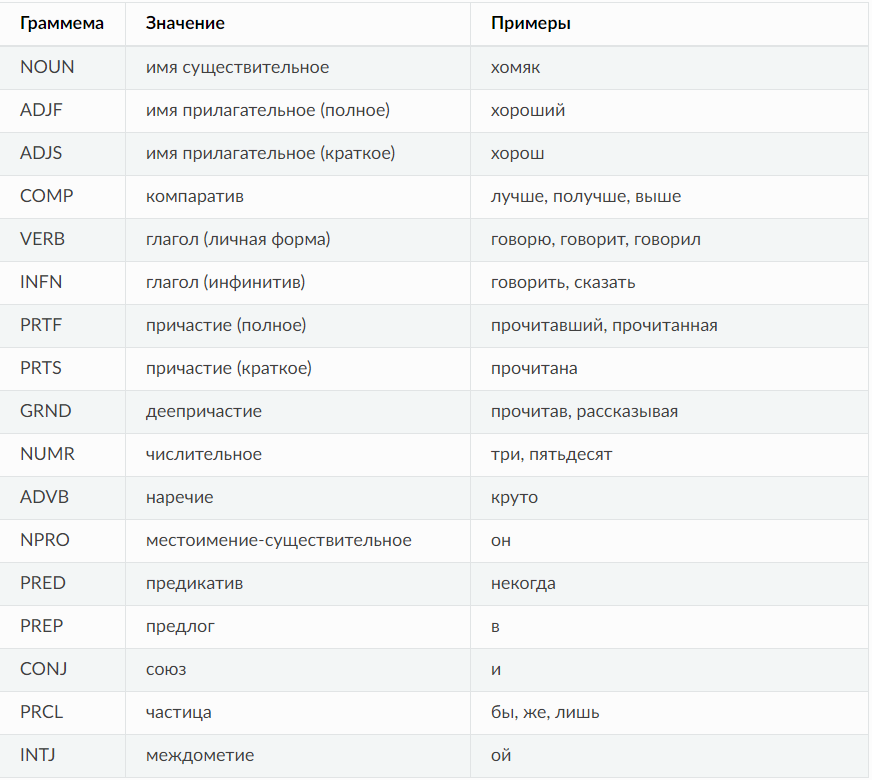

In [22]:
# Создаём словарь с частью речи для каждого токена
dict_pos = {}
keys = [x for x in range (0,201)] 
for doc_num in range (0, len(wout_sw)):
      dict_pos[doc_num] = [str(analyzer.parse(token)[0].tag.POS) for token in wout_sw[doc_num] if analyzer.parse(token)[0].tag.POS is not None
                           and (str(analyzer.parse(token)[0].tag.POS) == 'NOUN' or str(analyzer.parse(token)[0].tag.POS) == 'VERB'
                           or str(analyzer.parse(token)[0].tag.POS) == 'ADJF')]

In [25]:
dict_pos[2][:10]

['NOUN',
 'ADJF',
 'NOUN',
 'NOUN',
 'NOUN',
 'NOUN',
 'NOUN',
 'ADJF',
 'NOUN',
 'ADJF']

Создадим словарь, в котором будем хранить долю каждой части речи каждого документа

In [26]:
tags_percent = {}
for key, value in dict_pos.items():
    value_tags = collections.Counter(value)
    value_tags_percent = {}
    for key_, value_ in value_tags.items():
        value_tags_percent[key_] = value_ / sum(value_tags.values()) * 100
    tags_percent[key] = value_tags_percent

print(tags_percent[37])

{'ADJF': 22.727272727272727, 'NOUN': 63.63636363636363, 'VERB': 13.636363636363635}


In [27]:
corpus_tags = collections.defaultdict(list)
for doc in tags_percent.values():
    for tag, value in doc.items():
        corpus_tags[tag].append(value)

corpus_tags['VERB'][0:3]

[4.878048780487805, 13.333333333333334, 10.638297872340425]

In [38]:
corpus_tags

defaultdict(list,
            {'ADJF': [26.82926829268293,
              40.0,
              34.751773049645394,
              60.0,
              42.22222222222222,
              48.38709677419355,
              40.0,
              28.125,
              25.0,
              10.0,
              30.909090909090907,
              30.88235294117647,
              25.64102564102564,
              35.587188612099645,
              43.75,
              37.5,
              43.63636363636363,
              38.983050847457626,
              50.0,
              35.64356435643564,
              25.0,
              35.714285714285715,
              30.508474576271187,
              39.285714285714285,
              25.0,
              42.5287356321839,
              46.55172413793103,
              20.0,
              35.61643835616438,
              47.61904761904761,
              56.25,
              28.57142857142857,
              35.294117647058826,
              37.5,
              22.727272

In [28]:
pos_distribution = collections.defaultdict(list)
for tag, perc_list in corpus_tags.items():
    pos_distribution[tag].append(np.mean(perc_list))
    pos_distribution[tag].append(np.std(perc_list))

pos_distribution_sorted = {}
tags_sorted = sorted(pos_distribution, key=pos_distribution.get, reverse=True)
for tag in tags_sorted:
    pos_distribution_sorted[tag] = pos_distribution[tag]
for key, value in pos_distribution_sorted.items():
    print(key, value)

NOUN [57.304558745379346, 9.752350241069525]
ADJF [36.13340358040236, 9.707423586608376]
VERB [8.687768188401694, 3.7692550329783465]


In [29]:
odd_docs = collections.defaultdict(list)
for tag, params in pos_distribution_sorted.items():
    std_lower_boundary = params[0] - params[1] * 2
    std_upper_boundary = params[0] + params[1] * 2
    for key, doc in tags_percent.items():
        try:
            if not std_lower_boundary < doc[tag] < std_upper_boundary:
                # сохраняем id документа и часть речи с необычной долей
                odd_docs[key].append(tag)
                odd_docs[key].append(doc[tag])
        except KeyError:
            pass

In [39]:
print(odd_docs)

defaultdict(<class 'list'>, {10: ['NOUN', 90.0, 'ADJF', 10.0], 33: ['NOUN', 37.5, 'ADJF', 56.25], 90: ['NOUN', 30.0, 'ADJF', 60.0], 104: ['NOUN', 83.33333333333334, 'ADJF', 16.666666666666664], 107: ['NOUN', 80.0], 113: ['NOUN', 33.33333333333333, 'VERB', 16.666666666666664], 131: ['NOUN', 37.5], 139: ['NOUN', 80.0], 152: ['NOUN', 33.33333333333333, 'ADJF', 66.66666666666666], 3: ['ADJF', 60.0], 40: ['ADJF', 12.5, 'VERB', 16.666666666666664], 79: ['ADJF', 55.55555555555556], 110: ['ADJF', 9.090909090909092, 'VERB', 18.181818181818183], 130: ['ADJF', 56.52173913043478], 180: ['ADJF', 55.55555555555556], 190: ['ADJF', 57.14285714285714], 35: ['VERB', 17.647058823529413], 60: ['VERB', 17.0], 87: ['VERB', 16.43835616438356], 108: ['VERB', 20.0]})


In [31]:
odd_docs[104]

['NOUN', 83.33333333333334, 'ADJF', 16.666666666666664]

In [32]:
dict_corpus['104']

'Доза излучения — в радиационной безопасности, физике и радиобиологии — величина, используемая для оценки степени воздействия ионизирующего излучения на любые вещества, живые организмы и их ткани.'